# Chapter 3 Linear Regression

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

In [3]:
import statsmodels.api as sm

In [4]:
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [ ]:
from ISLP import load_data
from ISLP.models import (
    ModelSpec as MS,
    summarize,
    poly
)

## 3.1 Investigate Auto data

### 3.1.1 Simple Linear Regression

In [6]:
Auto = load_data('Auto')

Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


In [7]:
Auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


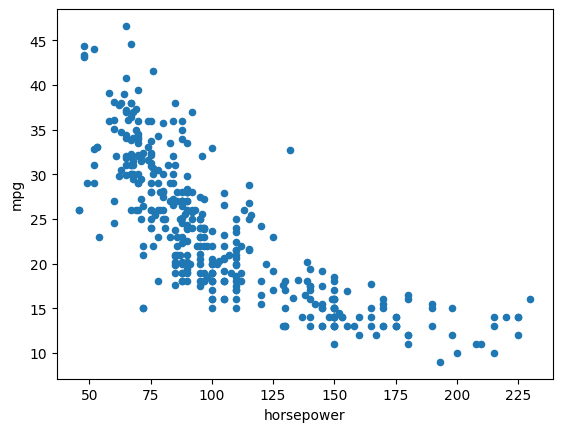

In [8]:
Auto.plot.scatter('horsepower', 'mpg');

In [9]:
design = MS(['horsepower'])

X = design.fit_transform(Auto)

X

,intercept,horsepower
name,,
chevrolet chevelle malibu,1.0,130
buick skylark 320,1.0,165
plymouth satellite,1.0,150
amc rebel sst,1.0,150
ford torino,1.0,140
...,...,...
ford mustang gl,1.0,86
vw pickup,1.0,52
dodge rampage,1.0,84


In [10]:
model = sm.OLS(Auto.mpg, X)

results = model.fit()

summarize(results)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


In [11]:
new_df = pd.DataFrame({'horsepower': [98]})

newX = design.transform(new_df)

new_predictions = results.get_prediction(newX)

new_predictions.predicted_mean

array([24.46707715])

In [12]:
new_predictions.conf_int(alpha=0.05)

array([[23.97307896, 24.96107534]])

In [13]:
new_predictions.conf_int(obs=True, alpha=0.05)

array([[14.80939607, 34.12475823]])

C:\Users\Aziz\AppData\Local\Temp\ipykernel_12436\989166159.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
C:\Users\Aziz\AppData\Local\Temp\ipykernel_12436\989166159.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


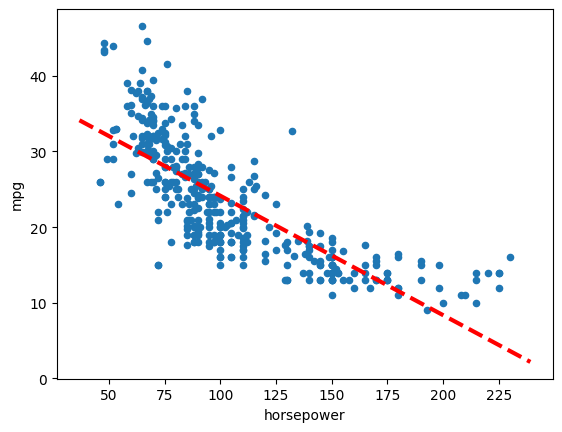

In [14]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Auto.plot.scatter('horsepower', 'mpg')

abline(
    ax,
    results.params[0],
    results.params[1],
    'r--',
    linewidth=3
);

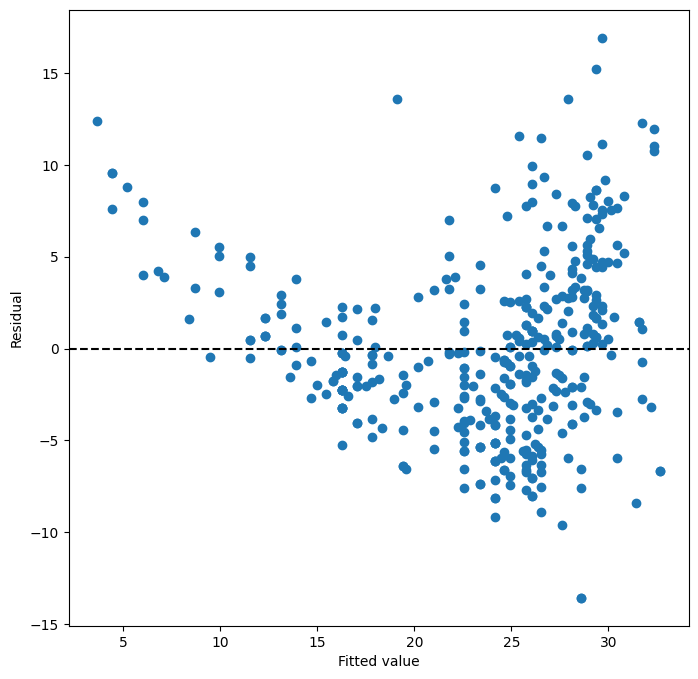

In [15]:
ax = subplots(figsize=(8,8))[1]

ax.scatter(results.fittedvalues, results.resid)

ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')

ax.axhline(0, c='k', ls='--');

np.int64(115)

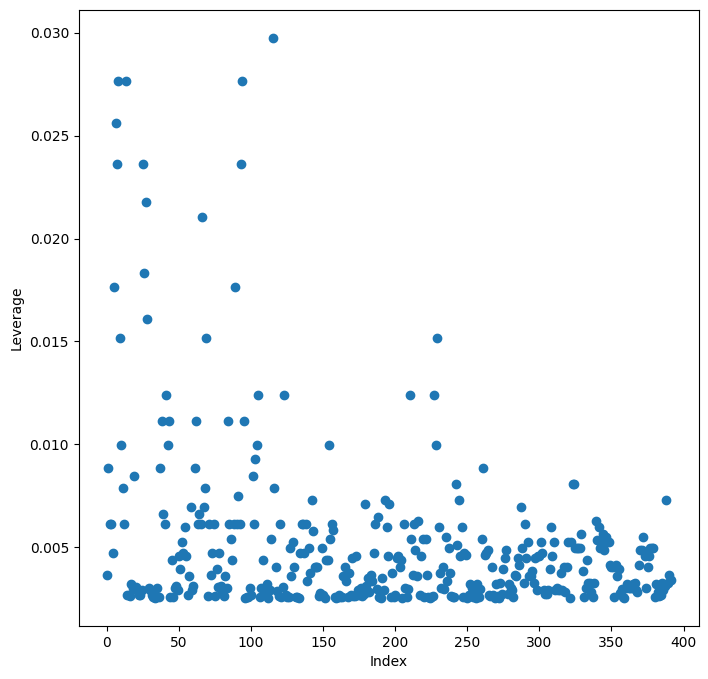

In [16]:
infl = results.get_influence()

ax = subplots(figsize=(8,8))[1]

ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)

ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

np.argmax(infl.hat_matrix_diag)

### 3.1.2 Multiple Linear Regression

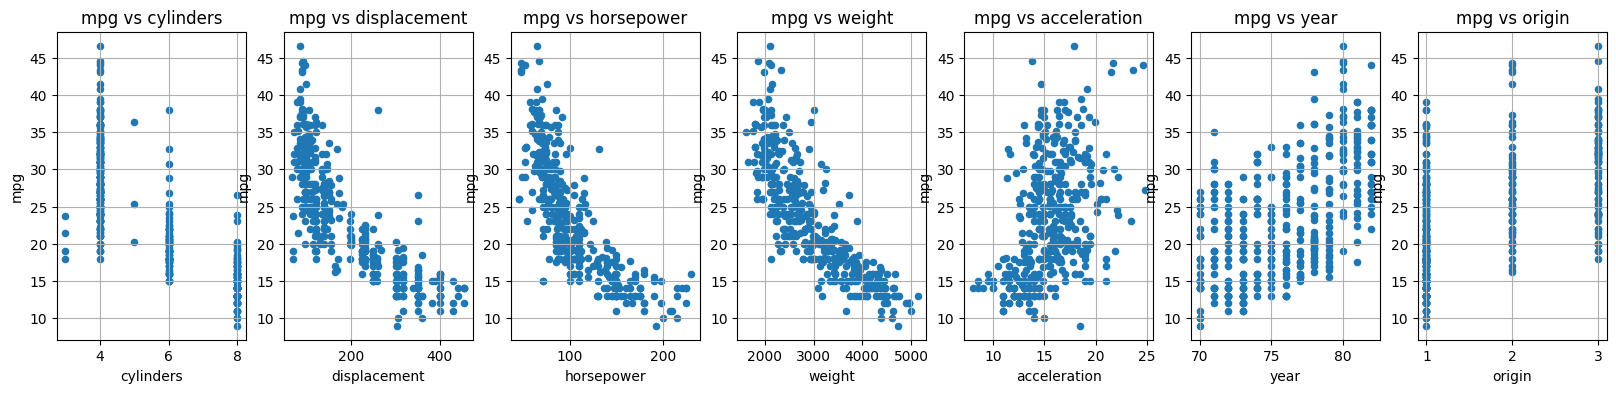

In [18]:
target_column = 'mpg'

columns = Auto.columns.drop(target_column)
fig, axes = subplots(1, len(columns), figsize=(20, 4))

for i, column in enumerate(columns):
    ax = axes[i]
    Auto.plot.scatter(x=column, y=target_column, ax=ax)
    ax.set_title(f'{target_column} vs {column}')
    ax.grid(True)

In [19]:
Auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [23]:
terms = Auto.columns.drop('mpg')

X = MS(terms).fit_transform(Auto)

model = sm.OLS(Auto.mpg, X)
results2 = model.fit()

summarize(results2)

,coef,std err,t,P>|t|
intercept,-17.2184,4.644,-3.707,0.000
cylinders,-0.4934,0.323,-1.526,0.128
displacement,0.0199,0.008,2.647,0.008
horsepower,-0.0170,0.014,-1.230,0.220
weight,-0.0065,0.001,-9.929,0.000
acceleration,0.0806,0.099,0.815,0.415
year,0.7508,0.051,14.729,0.000
origin,1.4261,0.278,5.127,0.000


In [24]:
anova_lm(results, results2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,384.0,4252.21253,0.0,NaN,NaN,NaN
1,384.0,4252.21253,-0.0,-0.0,NaN,NaN


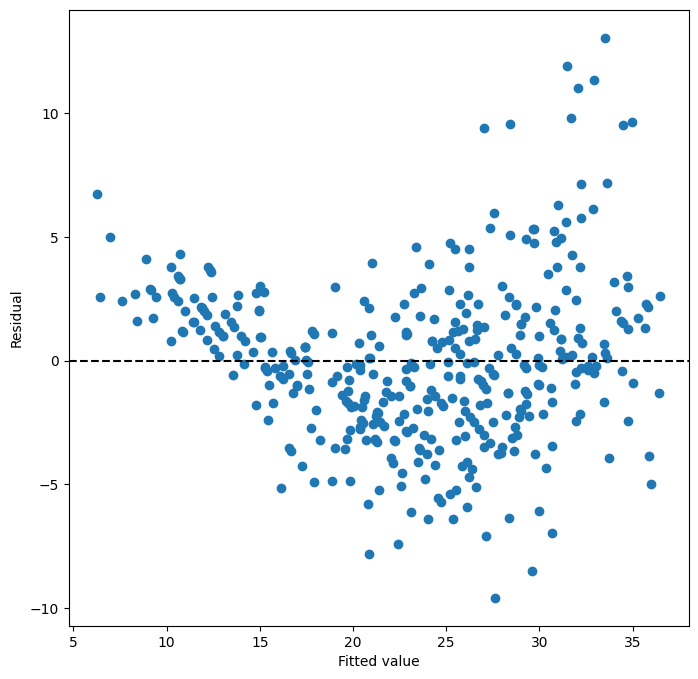

In [25]:
ax = subplots(figsize=(8,8))[1]

ax.scatter(results2.fittedvalues, results2.resid)

ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')

ax.axhline(0, c='k', ls='--');

np.int64(13)

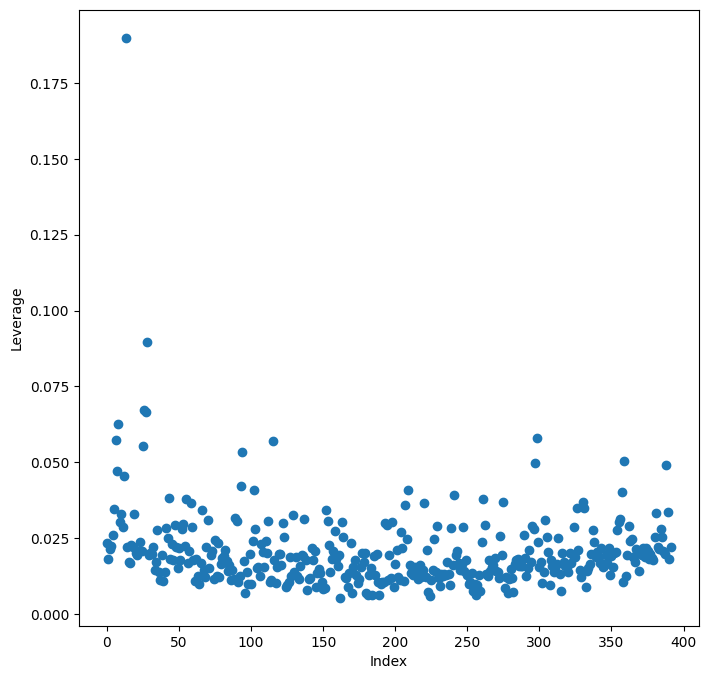

In [26]:
infl = results2.get_influence()

ax = subplots(figsize=(8,8))[1]

ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)

ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

np.argmax(infl.hat_matrix_diag)

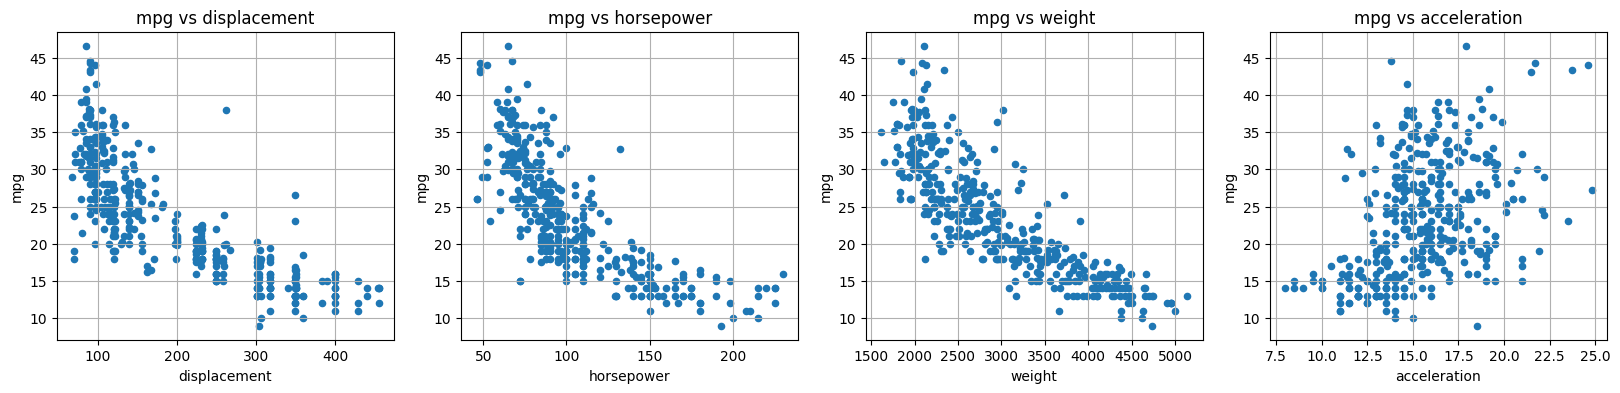

In [27]:
target_column = 'mpg'

columns = Auto.columns.drop([target_column, 'cylinders', 'year', 'origin'])
fig, axes = subplots(1, len(columns), figsize=(20, 4))

for i, column in enumerate(columns):
    ax = axes[i]
    Auto.plot.scatter(x=column, y=target_column, ax=ax)
    ax.set_title(f'{target_column} vs {column}')
    ax.grid(True)

In [28]:
X = MS(columns).fit_transform(Auto)

model = sm.OLS(Auto.mpg, X)
results3 = model.fit()

summarize(results3)

,coef,std err,t,P>|t|
intercept,45.2511,2.456,18.424,0.000
displacement,-0.0060,0.007,-0.894,0.372
horsepower,-0.0436,0.017,-2.631,0.009
weight,-0.0053,0.001,-6.512,0.000
acceleration,-0.0231,0.126,-0.184,0.854


In [30]:
X = MS([poly('displacement', degree=2), 'horsepower', 'weight', poly('acceleration', degree=2)]).fit_transform(Auto)

model = sm.OLS(Auto.mpg, X)
results4 = model.fit()

summarize(results4)

,coef,std err,t,P>|t|
intercept,41.2428,2.178,18.934,0.000
"poly(displacement, degree=2)[0]",-26.3697,13.460,-1.959,0.051
"poly(displacement, degree=2)[1]",33.6548,4.845,6.946,0.000
horsepower,-0.1049,0.017,-6.116,0.000
weight,-0.0023,0.001,-2.723,0.007
"poly(acceleration, degree=2)[0]",-12.8058,6.921,-1.850,0.065
"poly(acceleration, degree=2)[1]",9.1635,4.798,1.910,0.057


In [31]:
anova_lm(results3, results4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,387.0,6979.413203,0.0,NaN,NaN,NaN
1,385.0,5958.433260,2.0,1020.979943,32.984953,5.994941e-14


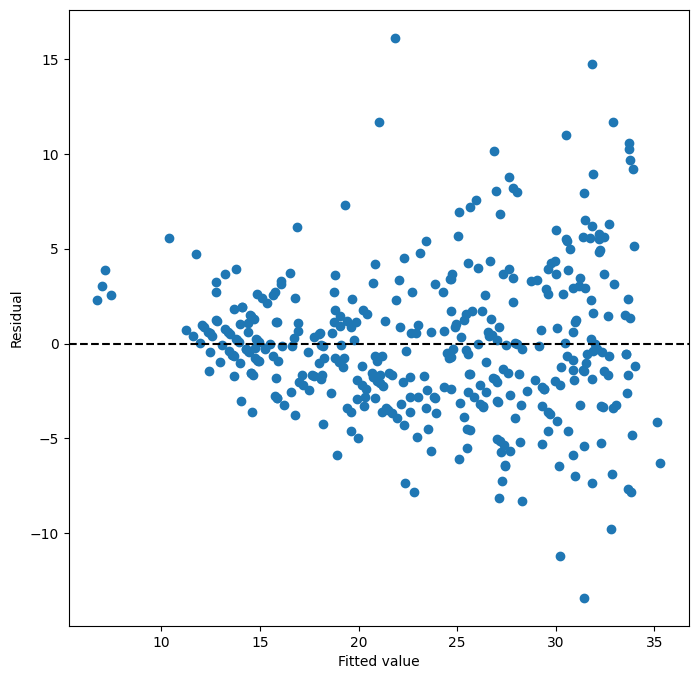

In [32]:
ax = subplots(figsize=(8,8))[1]

ax.scatter(results4.fittedvalues, results4.resid)

ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')

ax.axhline(0, c='k', ls='--');